# Create the anndata object

In [1]:
import anndata as ad
import scanpy as sc
import squidpy as sq
import tifffile
import pandas as pd
import swifter
import polars  as pl
import swifter
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
import geojson
import os
from scipy.spatial import ConvexHull
from shapely.geometry import shape
from shapely.geometry import MultiPoint
from shapely.ops import transform
import alphashape
from tqdm import tqdm

In [2]:
# Set the version of baysor that we want to use
v = 30
path = f"baysor_{str(v)}_mol_per_cell/"

We start by importing the counts. As you can see, the genes are in rows and the cells in the columns. We need to transpose the table (switch rows and columns) to be compatible with `anndata`

In [3]:
counts = pd.read_csv(path + "segmentation_counts.tsv",sep='\t', index_col='gene')
counts

,1,2,3,4,5,6,7,8,9,10,...,120685,120686,120687,120688,120689,120690,120691,120692,120693,120694
gene,,,,,,,,,,,,,,,,,,,,,
Abca2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Abcg1,0,0,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Acly,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Acta2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Adam12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zfas1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zfp683,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Znrf2,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, we import some more information about the cells. This includes the spatial coordinates and the size of the cell. Especially the spatial coordinates are important for some plotting functions.

In [4]:
cells = pd.read_csv(path + "segmentation_cell_stats.csv", index_col="cell")
cells

,x,y,cluster,n_transcripts,density,elongation,area,avg_confidence
cell,,,,,,,,
1,130.347934,1410.084088,5,507,3.197,1.744,158.600,1.0000
2,123.784174,1416.490865,2,416,4.164,1.319,99.900,0.9999
3,138.937365,1407.709821,5,393,2.659,1.545,147.800,0.9996
4,145.826591,1406.267540,2,172,2.533,1.929,67.900,1.0000
5,142.976419,1409.124042,2,16,2.022,4.211,7.914,1.0000
...,...,...,...,...,...,...,...,...
120690,2691.674300,669.079100,6,1,NaN,NaN,NaN,1.0000
120691,5225.633000,5751.088000,6,1,NaN,NaN,NaN,0.9999
120692,1583.965900,2634.434350,6,2,NaN,NaN,NaN,0.9998


We also want to add the cell boundaries. We can import the GeoPandas Dataframe from step 6 again and add that to the cells table

In [5]:
# Unfortunately the Polygons form Baysor are no good
# See: https://github.com/kharchenkolab/Baysor/issues/15
# gdf = gpd.read_file(path + "segmentation_polygons_joint.shp") 
# gdf

So instead we will create new polygons from the transcripts.
Let's import the transcripts

In [6]:
transcripts = pd.read_csv(path + "segmentation.csv")
transcripts

,Column1,x,y,z,gene,mask,molecule_id,prior_segmentation,confidence,cluster,cell,assignment_confidence,is_noise,ncv_color
0,0,3822.614000,134.603240,4.0,Pycr1,0,1,0,0.00000,8,0,1.00,True,#00B2FF
1,1,3865.508500,89.455734,5.0,Slc7a11,0,2,0,0.00000,4,0,1.00,True,#00B2FF
2,2,3972.906500,163.452200,6.0,Cxcr3,0,3,0,0.00000,8,0,1.00,True,#00B3FF
3,3,3968.895800,33.911680,0.0,Ldhb,0,4,0,0.00000,2,0,1.00,True,#00B2FF
4,5,3664.242700,184.795300,4.0,Slc2a2,0,5,0,0.00000,5,0,1.00,True,#9B8844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17720900,17812303,3266.297176,6421.473477,6.0,B2m,0,17720901,0,1.00000,5,68623,1.00,False,#9C4D00
17720901,17812304,3499.033270,6353.866514,6.0,B2m,136929,17720902,136929,1.00000,5,69774,0.66,False,#A90000
17720902,17812305,3502.489212,6355.486490,6.0,B2m,54100,17720903,54100,1.00000,5,69873,1.00,False,#C90000
17720903,17812306,3848.083411,6330.754869,6.0,B2m,0,17720904,0,1.00000,5,111888,0.28,False,#974600


Previously I have done that by creating a convex hull. However, an alphashape might acutally be nicer. So let's try that

In [7]:
# # this solution here is not ideal, as the polygons can overlap
# # but it is the best I can think of currently
# def make_polygons(transcripts):
#     points = transcripts[transcripts.cell != 0][['cell','x','y']]
#     points['poly'] = gpd.points_from_xy(points.x, points.y)
#     poly = points.groupby('cell')['poly'].agg(lambda x: MultiPoint(x.to_list()).convex_hull)
#     poly = gpd.GeoDataFrame(poly)
#     return(poly)

# poly = make_polygons(transcripts)
# poly

In [29]:
# this is from bento
def _make_alphashape(points_df,x_col = 'x', y_col = 'y',alpha=0.05,buffer=0):
    """Generate cell boundaries from points if they are already assigned to cell numbers.

    Parameters
    ----------
    points_df : GeoDataFrame
        Point coordinates.
    x_col : string
        Column header for 'X' coordinate.
    y_col : string
        Column header for 'Y' coordinate.
    alpha : float
        Alpha parameter for generating an alpha shape around the group of points.
    buffer: int
        Additional padding around the points if needed. 0 by default
    Returns
    -------
    cell_seg: Polygon
        Return a shapely Polygon object as a cell segmentation mask.
    """
    points = np.array([points_df[x_col],points_df[y_col]]).T
    # create unique points
    points = np.unique(points, axis=0)
    cell_seg = alphashape.alphashape(points, alpha).buffer(buffer)
    return cell_seg

In [34]:
points = transcripts[transcripts.cell != 0][['cell','x','y', 'gene']]
points = points.set_index('cell')
points

,x,y,gene
cell,,,
12569,3519.302200,155.489910,Klf6
12646,3512.186300,166.390230,Klf6
12765,3536.425300,170.964000,Klf6
12765,3524.853300,171.396010,Klf6
12834,3517.636500,171.748400,Klf6
...,...,...,...
68623,3266.297176,6421.473477,B2m
69774,3499.033270,6353.866514,B2m
69873,3502.489212,6355.486490,B2m


In [35]:
tqdm.pandas()

In [36]:
%time poly = points.groupby('cell').progress_apply(_make_alphashape, alpha=.05)

100%|█████████████████████████████████████████████████████████████████████████| 120694/120694 [44:49<00:00, 44.88it/s]

CPU times: user 44min 42s, sys: 7.81 s, total: 44min 50s
Wall time: 44min 49s


In [37]:
# fig = plt.figure(figsize=(8,5))
# ax = fig.subplots()
# ax.scatter(points.x, points.y)
# gpd.GeoSeries(poly).boundary.plot(ax = ax)

In [38]:
poly = gpd.GeoDataFrame({'cell_shape': poly})
poly

,cell_shape
cell,
1,"POLYGON ((121.90738 1410.9453, 125.958466 1414..."
2,"POLYGON ((119.71684 1412.4857, 118.00169 1416...."
3,"POLYGON ((145.00394 1410.3529, 145.53467 1406...."
4,"POLYGON ((143.04446 1401.9124, 142.22736 1402...."
5,"POLYGON ((141.25397 1406.9685, 140.95296 1407...."
...,...
120690,POLYGON EMPTY
120691,POLYGON EMPTY
120692,POLYGON EMPTY


In [39]:
cells.shape

(120694, 8)

In [40]:
# merge cells and poly
obs = cells.join(poly)
obs

,x,y,cluster,n_transcripts,density,elongation,area,avg_confidence,cell_shape
cell,,,,,,,,,
1,130.347934,1410.084088,5,507,3.197,1.744,158.600,1.0000,"POLYGON ((121.90738 1410.9453, 125.958466 1414..."
2,123.784174,1416.490865,2,416,4.164,1.319,99.900,0.9999,"POLYGON ((119.71684 1412.4857, 118.00169 1416...."
3,138.937365,1407.709821,5,393,2.659,1.545,147.800,0.9996,"POLYGON ((145.00394 1410.3529, 145.53467 1406...."
4,145.826591,1406.267540,2,172,2.533,1.929,67.900,1.0000,"POLYGON ((143.04446 1401.9124, 142.22736 1402...."
5,142.976419,1409.124042,2,16,2.022,4.211,7.914,1.0000,"POLYGON ((141.25397 1406.9685, 140.95296 1407...."
...,...,...,...,...,...,...,...,...,...
120690,2691.674300,669.079100,6,1,NaN,NaN,NaN,1.0000,POLYGON EMPTY
120691,5225.633000,5751.088000,6,1,NaN,NaN,NaN,0.9999,POLYGON EMPTY
120692,1583.965900,2634.434350,6,2,NaN,NaN,NaN,0.9998,POLYGON EMPTY


We also want to add the transcripts to `uns` in anndata. We need to keep the columns gene, cell, x and y

In [41]:
uns = {
    'points': transcripts[['gene', 'cell', 'x', 'y']]
}
uns

{'points':              gene    cell            x            y
 0           Pycr1       0  3822.614000   134.603240
 1         Slc7a11       0  3865.508500    89.455734
 2           Cxcr3       0  3972.906500   163.452200
 3            Ldhb       0  3968.895800    33.911680
 4          Slc2a2       0  3664.242700   184.795300
 ...           ...     ...          ...          ...
 17720900      B2m   68623  3266.297176  6421.473477
 17720901      B2m   69774  3499.033270  6353.866514
 17720902      B2m   69873  3502.489212  6355.486490
 17720903      B2m  111888  3848.083411  6330.754869
 17720904      B2m   72862  3905.538447  6375.466183
 
 [17720905 rows x 4 columns]}

In [42]:
uns['points']

,gene,cell,x,y
0,Pycr1,0,3822.614000,134.603240
1,Slc7a11,0,3865.508500,89.455734
2,Cxcr3,0,3972.906500,163.452200
3,Ldhb,0,3968.895800,33.911680
4,Slc2a2,0,3664.242700,184.795300
...,...,...,...,...
17720900,B2m,68623,3266.297176,6421.473477
17720901,B2m,69774,3499.033270,6353.866514
17720902,B2m,69873,3502.489212,6355.486490
17720903,B2m,111888,3848.083411,6330.754869


In [43]:
var = pd.DataFrame({
    'Symbol': counts.index
})
var = var.set_index('Symbol')
var

""
Symbol
Abca2
Abcg1
Acly
Acta2
Adam12
...
Zfas1
Zfp683
Znrf2


Let's create a first `anndata` obeject. 

In [44]:
adata = ad.AnnData(
    X = counts.transpose().to_numpy(dtype = np.float32),
    obs = obs,
    obsm={"spatial": cells[['x', 'y']].to_numpy()},
    uns = uns,
    var = var
)
adata

/projects/ps-yeolab5/t_cell_p01/home/mheeg/mambaforge/envs/cellpose/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 120694 × 499
    obs: 'x', 'y', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'cell_shape'
    uns: 'points'
    obsm: 'spatial'

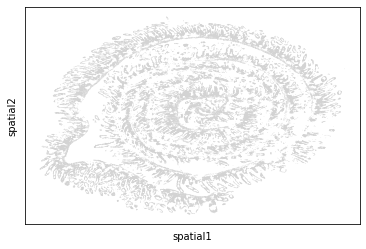

In [45]:
sc.pl.embedding(adata, basis="spatial")

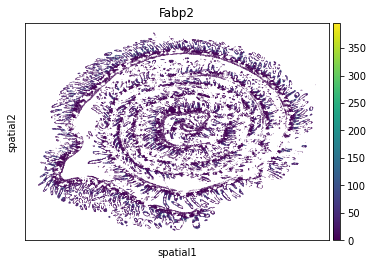

In [46]:
sc.pl.embedding(adata, color="Fabp2", basis="spatial")

In [47]:
# Convert geometry from GeoSeries to list for h5ad serialization compatibility
adata = adata.copy()

adata.obs = adata.obs.apply(
    lambda col: col.apply(lambda val: val.wkt if val is not None else val).astype(
        str
    )
    if col.astype(str).str.startswith("POLYGON").any()
    else col
)

In [48]:
adata.write(filename=path+"anndata.h5ad")

In [49]:
adata.obs['cell_shape']

cell
1         POLYGON ((121.90738 1410.9453, 125.958466 1414...
2         POLYGON ((119.71684 1412.4857, 118.00169 1416....
3         POLYGON ((145.00394 1410.3529, 145.53467 1406....
4         POLYGON ((143.04446 1401.9124, 142.22736 1402....
5         POLYGON ((141.25397 1406.9685, 140.95296 1407....
                                ...                        
120690                                        POLYGON EMPTY
120691                                        POLYGON EMPTY
120692                                        POLYGON EMPTY
120693                                        POLYGON EMPTY
120694                                        POLYGON EMPTY
Name: cell_shape, Length: 120694, dtype: category
Categories (117869, object): ['MULTIPOLYGON (((2277.3108 1000.97864, 2278.28..., 'POLYGON ((20.75769 1634.7267, 23.293108 1638...., 'POLYGON ((24.627798 1641.6558, 24.294823 1642..., 'POLYGON ((25.686134 1636.1595, 24.690582 1636..., ..., 'POLYGON ((6063.0376 4178.1567, 6062.3857 4175

# Create plots with the new alphashape cell boundaries

In [50]:
def create_rescaling_function():
    """
    Here we create a rescaling function that takes three argument: x, y, z.
    These are the coordinates of out point. We will apply the transformation
    defined in 'micron_to_mosaic_pixel_transform' to convert the micron to pixel
    and then rescale it with the same scaling factor used in script '01'
    """
    # the get the size of the original image, we can take any of the images
    # they are all the same size
    size_original_image = tifffile.imread("../Merlin_output/images/mosaic_Cellbound2_z0.tif").shape
    
    # rescaled image
    size_rescaled_image = tifffile.imread("image/full_stack.tif").shape
    # since this is the stacked image, we dont need to keep all dimensions.
    size_rescaled_image = size_rescaled_image[2:4]
    
    scale_y = size_original_image[0] / size_rescaled_image[0]
    scale_x = size_original_image[1] / size_rescaled_image[1]
    rescale = np.array([scale_x, scale_y, 1])
    
    
    mmpt = pd.read_csv(
        "../Merlin_output/images/micron_to_mosaic_pixel_transform.csv", 
        header=None, 
        sep=' '
    )
    mmpt = np.array(mmpt)

    def rescale_fun(x,y,z):
        points = np.array([x,y,z])
        # coordinates to pixel
        points = np.diag(mmpt) * points.T + np.append(mmpt[0:2,2], 0)
        # apply our scaling
        points = points / rescale
        return(points.T)
    
    return(rescale_fun)

In [51]:
rescale_fun = create_rescaling_function()
rescale_fun

Shaped series: series shape does not match page shape


(3.0865665011414225, 3.0865709219772635)

In [52]:
img = tifffile.imread("cellpose_segmentation/full_stack.tif")[3]

In [53]:
def make_image(img):
    """ Function to format the np array for plotting
    
    Takes a np array of dimensions (2 x Y x X) and
    formats it to Y x X x 3.
    Third color is filled with zeros.
    
    """
    
    # move the RGB to the third dimension
    img = np.transpose(img, [1,2,0])
    zeros = np.zeros(
                [img.shape[0], img.shape[1], 1],
                dtype = np.uint8
            )
    
    # fill R(ed) with zeros
    img = np.concatenate(
        [zeros,img],
        axis = 2
    )
    
    # scale the colors from 0 to 255 to make it more intense
    img[:,:,1] = np.uint8(img[:,:,1] / np.max(img[:,:,1]) * 255)
    img[:,:,2] = np.uint8(img[:,:,2] / np.max(img[:,:,2]) * 255)
    
    
    return(img)

In [105]:
# remove empty polygons, these cause an error for plotting
poly_draw = gpd.GeoSeries(poly.cell_shape)
poly_draw = poly_draw[~poly_draw.is_empty]
poly_draw

cell
1         POLYGON ((121.907 1410.945, 125.958 1414.014, ...
2         POLYGON ((119.717 1412.486, 118.002 1416.133, ...
3         POLYGON ((145.004 1410.353, 145.535 1406.199, ...
4         POLYGON ((143.044 1401.912, 142.227 1402.037, ...
5         POLYGON ((141.254 1406.968, 140.953 1407.200, ...
                                ...                        
120655    POLYGON ((209.430 2536.272, 208.787 2535.732, ...
120667    POLYGON ((1675.971 3072.208, 1674.777 3072.812...
120670    POLYGON ((2604.101 3175.266, 2603.863 3175.968...
120681    POLYGON ((5311.925 4714.247, 5309.319 4715.523...
120687    POLYGON ((3972.193 4236.158, 3972.064 4236.481...
Name: cell_shape, Length: 117868, dtype: geometry

In order to plot the polygon, we need to transform the position to the image pixed for the polygons too. The polygons only have x and y (2d). But we can easlily create the 2d wrapper function around `rescale_fun`. This then can be applied to the Geopandas polygon (see the example below)

In [ ]:
def rescale_fun_2d(x,y):
    ones = np.ones(len(x))
    res = rescale_fun(x,y,ones)
    return(res[0],res[1])
    

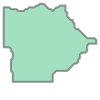

In [ ]:
transform(rescale_fun_2d, boundaries.geometry[0])

In [ ]:
fig = plt.figure(figsize = (250,250))
ax = fig.add_subplot(111)
print(">>> plotting image")
ax.imshow(
    make_image(img),
    interpolation = "nearest",
    origin='lower'
)
print(">>> plotting transcripts")
ax.scatter(transcripts.x*scales[0], transcripts.y*scales[1], s=0.05, c=transcripts.ncv_color)
print(">>> plotting cell boundaries")
poly_draw.geometry.apply(lambda x: transform(rescale_fun_2d, x)).boundary.plot(ax = ax, linewidth=0.5, edgecolor="red")
ax.axis('off')
fig.tight_layout()
print(">>> saving jpg")
fig.savefig(path+'/alphashape.jpg', dpi = 100)